In [ ]:
from outlier_detector import OutlierDetector
from pyod.models.knn import KNN
from pyod.models.iforest import IForest

from aggregator import AndAggregator

from sktime.transformations.series.impute import Imputer
from conditional_imputer import ConditionalImputer

import pandas as pd
import plotly.graph_objects as go

In [3]:
pyod_iforest_detector = IForest(contamination=0.005) 
sktime_iforest_detector = OutlierDetector(pyod_iforest_detector)

pyod_knn_detector = IForest(contamination=0.005) 
sktime_knn_detector = OutlierDetector(pyod_knn_detector)

In [4]:
df = pd.read_csv("nyc_taxi.csv")
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [5]:
sktime_iforest_detector.fit(df['value'])

OutlierDetector(estimator=IForest(behaviour='old', bootstrap=False, contamination=0.005,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=None, verbose=0))

In [6]:
sktime_iforest_detector.transform(df['value']).value_counts()#.isna().sum()

False    10269
True        51
Name: value, dtype: int64

In [7]:
df['anomaly_isoforest'] = sktime_iforest_detector.transform(df['value'])

In [8]:
layout = go.Layout(plot_bgcolor='#F0E9E6')
fig = go.Figure(layout=layout)

fig.add_trace(
    go.Scatter(
    x=df["timestamp"],
    y=df['value'],
    line=dict(color='#7A95BB', width=2),
    mode='lines',
    name='Taxi Bookings'
    )
)
fig.add_trace(
    go.Scatter(
    x=df.loc[df['anomaly_isoforest']==True]["timestamp"],
    y=df.loc[df['anomaly_isoforest']==True]['value'],
    line=dict(color='#082255', width=2),
    mode='markers',
    name='Anomalies'
    )
)

fig.update_layout(
                   title='Taxi Data Anomaly Detection',
                   xaxis_title='Time',
                   yaxis_title='Taxi Books', 
                   xaxis_showgrid=False, 
                   yaxis_showgrid=False
)

#fig.write_image("anomaly.png")
import plotly
plotly.offline.plot(fig, filename = 'filename.html', auto_open=False)

'filename.html'

In [24]:
pyod_iforest_detector = IForest(contamination=0.005) 
sktime_iforest_detector = OutlierDetector(pyod_iforest_detector)

pyod_knn_detector = IForest(contamination=0.005) 
sktime_knn_detector = OutlierDetector(pyod_knn_detector)

In [25]:
and_aggreagtor = AndAggregator(sktime_iforest_detector,sktime_knn_detector)
and_aggreagtor.fit(df['value'])
and_aggreagtor.predict(df['value'])

(OutlierDetector(estimator=IForest(behaviour='old', bootstrap=False, contamination=0.005,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=None, verbose=0)), OutlierDetector(estimator=IForest(behaviour='old', bootstrap=False, contamination=0.005,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=None, verbose=0)))


0        False
1        False
2        False
3        False
4        False
         ...  
10315    False
10316    False
10317    False
10318    False
10319    False
Length: 10320, dtype: bool

In [11]:
imputer = Imputer(method="mean")
pyod_iforest_detector = IForest(contamination=0.005) 
sktime_iforest_detector = OutlierDetector(pyod_iforest_detector)
conditional_imputer = ConditionalImputer(imputer, sktime_iforest_detector)

In [12]:
conditional_imputer.fit(df['value'])

ConditionalImputer(detector=OutlierDetector(estimator=IForest(behaviour='old', bootstrap=False, contamination=0.005,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=None, verbose=0)),
                   imputer=Imputer(method='mean'))

In [13]:
conditional_imputer.transform(df['value'])

Debug (10320,)


0        10844.0
1         8127.0
2         6210.0
3         4656.0
4         3820.0
          ...   
10315    24670.0
10316    25721.0
10317    27309.0
10318    26591.0
10319    26288.0
Name: value, Length: 10320, dtype: float64

Debug (10320,)


<AxesSubplot:>

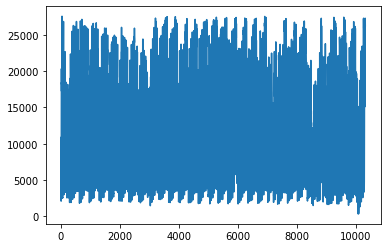

In [28]:
conditional_imputer.transform(df['value']).plot()

<AxesSubplot:>

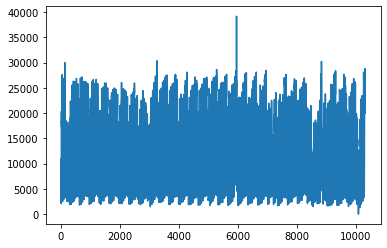

In [29]:
df['value'].plot()

In [14]:
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.compose import (
    TransformedTargetForecaster
)
import numpy as np 
from sktime.forecasting.model_selection import (
    temporal_train_test_split,
)
from sktime.utils.plotting import plot_series

from sktime.forecasting.naive import NaiveForecaster

In [15]:
y = pd.read_csv("nyc_taxi.csv",index_col="timestamp",parse_dates=["timestamp"])
y = y['value']
y.index= y.index.to_period()
y.head()

timestamp
2014-07-01 00:00    10844
2014-07-01 00:30     8127
2014-07-01 01:00     6210
2014-07-01 01:30     4656
2014-07-01 02:00     3820
Freq: 30T, Name: value, dtype: int64

7224 3096


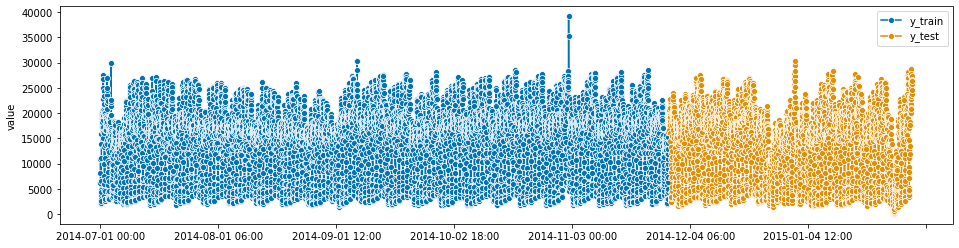

In [16]:
y_train, y_test = temporal_train_test_split(y, test_size=0.3)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

In [17]:
fh = np.arange(len(y_test)) + 1
fh

array([   1,    2,    3, ..., 3094, 3095, 3096])

In [18]:
forecaster = TransformedTargetForecaster(
    [
        
        ("outlier_detector", ConditionalImputer(imputer, sktime_iforest_detector)),
        (
            "forecast",NaiveForecaster()
        ),
    ]
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

PeriodIndex(['2014-07-01 00:00', '2014-07-01 00:30', '2014-07-01 01:00',
             '2014-07-01 01:30', '2014-07-01 02:00', '2014-07-01 02:30',
             '2014-07-01 03:00', '2014-07-01 03:30', '2014-07-01 04:00',
             '2014-07-01 04:30',
             ...
             '2014-11-28 07:00', '2014-11-28 07:30', '2014-11-28 08:00',
             '2014-11-28 08:30', '2014-11-28 09:00', '2014-11-28 09:30',
             '2014-11-28 10:00', '2014-11-28 10:30', '2014-11-28 11:00',
             '2014-11-28 11:30'],
            dtype='period[30T]', name='timestamp', length=7224, freq='30T') PeriodIndex(['2014-07-01 00:00', '2014-07-01 00:30', '2014-07-01 01:00',
             '2014-07-01 01:30', '2014-07-01 02:00', '2014-07-01 02:30',
             '2014-07-01 03:00', '2014-07-01 03:30', '2014-07-01 04:00',
             '2014-07-01 04:30',
             ...
             '2014-11-28 07:00', '2014-11-28 07:30', '2014-11-28 08:00',
             '2014-11-28 08:30', '2014-11-28 09:00', '2014-1

In [21]:
pyod_iforest_detector = IForest(contamination=0.005) 
sktime_iforest_detector = OutlierDetector(pyod_iforest_detector)

pyod_knn_detector = IForest(contamination=0.005) 
sktime_knn_detector = OutlierDetector(pyod_knn_detector)

and_aggreagtor = AndAggregator(sktime_iforest_detector,sktime_knn_detector)

In [22]:
forecaster = TransformedTargetForecaster(
    [
        
        ("outlier_detector", ConditionalImputer(imputer, and_aggreagtor)),
        (
            "forecast",NaiveForecaster()
        ),
    ]
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

RuntimeError: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'aggregator.AndAggregator'> with constructor (self, *detectors) doesn't  follow this convention.